In [1]:
%load_ext cython
import numpy as np
import h5py
import pickle

In [2]:
%%cython -f -+ -I/usr/local/include --link-args=-Wl,-rpath,/usr/local/lib -lm -L/usr/local/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/gilles/gdrive/research/sandbox/learning-qcd-rnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=1.0, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array([e for e in tree]).reshape(-1, 2)
        content = np.array([e for e in content]).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

In [5]:
# f = h5py.File("../data/w-vs-qcd/h5/w_100000.h5", "r")
# f = h5py.File("../data/w-vs-qcd/h5/qcd_100000.h5", "r")
# f = h5py.File("../data/w-vs-qcd/h5/w_100000_delphes.h5", "r")
f = h5py.File("../data/w-vs-qcd/h5/qcd_100000_delphes.h5", "r")
events = f["events"]

def cast(event):
    a = np.zeros((len(event), 4))
    for i, p in enumerate(event):
        a[i, 3] = p[0]
        a[i, 0] = p[1]
        a[i, 1] = p[2]
        a[i, 2] = p[3]
    return a

# fd = open("../data/w-vs-qcd/kt/kt-w.pickle", "wb")
# fd = open("../data/w-vs-qcd/kt/kt-qcd.pickle", "wb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-w.pickle", "wb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-qcd.pickle", "wb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-delphes-w.pickle", "wb")
fd = open("../data/w-vs-qcd/anti-kt/antikt-delphes-qcd.pickle", "wb")

for e in events:
    tree, content, mass, pt = cluster(cast(e), jet_algorithm=1)[0]  # dump highest pt jet only
    
    jet = {}
    
    jet["root_id"] = 0
    jet["tree"] = tree
    jet["content"] = content
    jet["mass"] = mass
    jet["pt"] = pt
    jet["energy"] = content[0, 3]

    px = content[0, 0]
    py = content[0, 1]
    pz = content[0, 2]
    p = (content[0, 0:3] ** 2).sum() ** 0.5
    eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
    phi = np.arctan2(py, px)
    
    jet["eta"] = eta
    jet["phi"] = phi
    
    pickle.dump(jet, fd, protocol=2)
    
fd.close()

---

In [2]:
#f = h5py.File("../data/w-vs-qcd/h5/qcd_100000_j1p0_sj0p30_delphes_jets_images.h5", "r")
f = h5py.File("../data/w-vs-qcd/h5/w_100000_j1p0_sj0p30_delphes_jets_images.h5", "r")
auxvars = f["auxvars"].value
events = f["images"].value
edges = np.linspace(-1, 1, 26)
bins = (edges[:25] + edges[1:]) / 2.

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


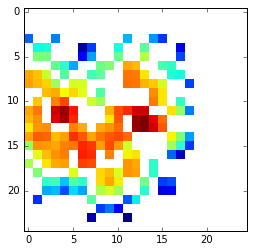

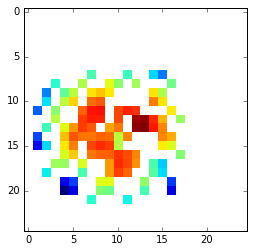

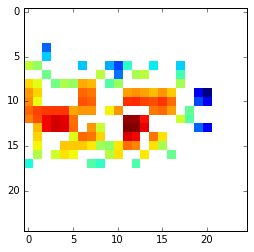

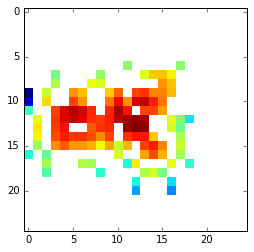

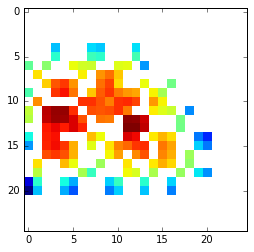

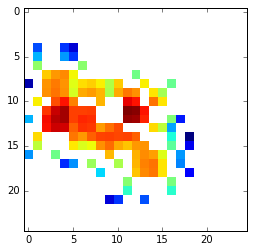

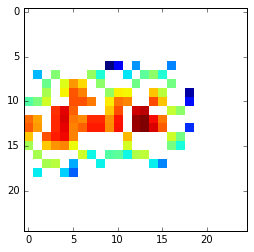

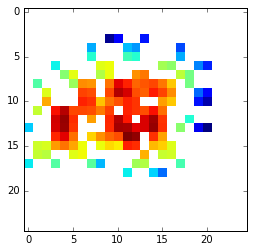

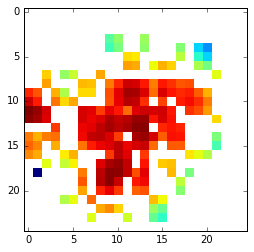

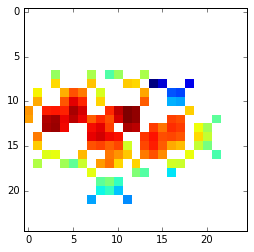

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(len(events[:10])):
    img = events[i]
    img = img * auxvars[i][1] / img.sum()
    plt.imshow(np.log(img), interpolation="nearest")
    plt.savefig("img-%d.png" % i)
    plt.show()

In [109]:
from rootpy.vector import LorentzVector

# fd = open("../data/w-vs-qcd/anti-kt/images-qcd.pickle", "wb")
fd = open("../data/w-vs-qcd/anti-kt/images-w.pickle", "wb")

for i in range(len(events)):
    img = events[i]
    img = img * auxvars[i][1] / img.sum()
    content = []
    
    for r, c in zip(*np.where(img)):
        eta = bins[r]
        phi = bins[c]
        pt = img[r, c]
        v = LorentzVector()
        v.set_pt_eta_phi_m(pt, eta, phi, 0.0)
        content.append((v.px, v.py, v.pz, v.E()))
    
    content = np.array(content)
    
    jet = {}
    
    tree, content, mass, pt = cluster(content, jet_algorithm=0, R=100)[0]  # recluster using KT, no further processing
    
    jet["root_id"] = 0
    jet["tree"] = tree
    jet["content"] = content
    jet["mass"] = mass
    jet["pt"] = pt
    jet["energy"] = content[0, 3]

    px = content[0, 0]
    py = content[0, 1]
    pz = content[0, 2]
    p = (content[0, 0:3] ** 2).sum() ** 0.5
    eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
    phi = np.arctan2(py, px)
    
    jet["eta"] = eta
    jet["phi"] = phi
    
    pickle.dump(jet, fd, protocol=2)
    
fd.close()

---

In [13]:
# event level data, decomposed as anti-kt trees

# f = h5py.File("../data/w-vs-qcd/h5/w_100000.h5", "r")
# f = h5py.File("../data/w-vs-qcd/h5/qcd_100000.h5", "r")
# f = h5py.File("../data/w-vs-qcd/h5/w_100000_delphes.h5", "r")
f = h5py.File("../data/w-vs-qcd/h5/qcd_100000_delphes.h5", "r")
events = f["events"]

def cast(event):
    a = np.zeros((len(event), 4))
    for i, p in enumerate(event):
        a[i, 3] = p[0]
        a[i, 0] = p[1]
        a[i, 1] = p[2]
        a[i, 2] = p[3]
    return a


# fd = open("../data/w-vs-qcd/anti-kt/antikt-w-event.pickle", "wb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-qcd-event.pickle", "wb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-delphes-w-event.pickle", "wb")
fd = open("../data/w-vs-qcd/anti-kt/antikt-delphes-qcd-event.pickle", "wb")

for i, e in enumerate(events):
    if i % 1000 == 0:
        print(i)
    
    jets = []
    
    for tree, content, mass, pt in cluster(cast(e), jet_algorithm=1):
        jet = {}

        jet["root_id"] = 0
        jet["tree"] = tree
        jet["content"] = content
        jet["mass"] = mass
        jet["pt"] = pt
        jet["energy"] = content[0, 3]

        px = content[0, 0]
        py = content[0, 1]
        pz = content[0, 2]
        p = (content[0, 0:3] ** 2).sum() ** 0.5
        eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
        phi = np.arctan2(py, px)

        jet["eta"] = eta
        jet["phi"] = phi
        jets.append(jet)
    
    pickle.dump(jets, fd, protocol=pickle.HIGHEST_PROTOCOL)
    
fd.close()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
